In [3]:
%matplotlib inline
#from ROOT import TFile, TTree

import numpy as np
#from numpy import polyfit
#from numpy import random
import matplotlib.pylab as plt
#from matplotlib.colors import LogNorm
import pandas as pd
#from matplotlib import gridspec
#from scipy.stats import norm

from root_numpy import root2array

In [4]:
filedir = '/Users/davidkaleko/larlite/UserDev/KalekoAna/scratch_ana/mac/MCS_paper_anafiles/'

anatype = 'singletrack_data' #singlemu_recotracks, singletrack_data, singlemu_mctracks

seglen = 20
fb = ['FORWARDS', 'BACKWARDS']
!ls $filedir

MCSBiasStudy_singlemu_mctracks_anaout_20cmseg_2res_bothscatters.root
MCSBiasStudy_singlemu_recotracks_anaout_20cmseg_2res_bothscatters.root
MCSBiasStudy_singletrack_data_anaout_20cmseg_2res_bothscatters.root
MCSBiasStudy_singletrack_data_anaout_20cmseg_2res_bothscatters_BACKWARDS.root
MCSBiasStudy_singletrack_data_anaout_20cmseg_2res_bothscatters_FORWARDS.root


In [6]:
df_dict = {}
segdf_dict = {}

for myfb in fb:
    myfile = 'MCSBiasStudy_%s_anaout_%dcmseg_2res_bothscatters_%s.root' % (anatype, seglen, myfb)
    
    df_dict[myfb] = pd.DataFrame( root2array ( filedir + myfile, 'MCS_bias_tree' ) )
    #This df has track-by-track information (MCS energy, range energy, etc)
    df_dict[myfb]['full_MCS_energy_inverse'] = 1./df_dict[myfb]['full_MCS_energy']
    df_dict[myfb]['full_range_energy_inverse'] = 1./df_dict[myfb]['full_range_energy']
    
    #This df has segment-by-segment deviation (scattering angle, etc)
    segdf_dict[myfb] = pd.DataFrame( root2array ( filedir + myfile, 'TMC_debug_tree' ) )
    segdf_dict[myfb]['dthetayoverpredictedRMS'] = \
        segdf_dict[myfb]['delta_theta_y']/segdf_dict[myfb]['predicted_RMS']
    segdf_dict[myfb]['dthetayoverpredictedRMS_fromMCS'] = \
        segdf_dict[myfb]['delta_theta_y']/segdf_dict[myfb]['predicted_RMS_fromMCS']
    
    segdf_dict[myfb]['dthetaxoverpredictedRMS'] = \
        segdf_dict[myfb]['delta_theta_x']/segdf_dict[myfb]['predicted_RMS']
    segdf_dict[myfb]['dthetaxoverpredictedRMS_fromMCS'] = \
        segdf_dict[myfb]['delta_theta_x']/segdf_dict[myfb]['predicted_RMS_fromMCS']


In [7]:
print segdf_dict['FORWARDS'].columns.values

['full_track_len' 'full_MCS_E' 'full_range_E' 'delta_theta_x'
 'delta_theta_y' 'seg_end_x' 'seg_end_y' 'seg_end_z' 'n_traj_points'
 'seg_theta' 'seg_phi' 'counter' 'true_segment_E' 'true_predicted_RMS'
 'segment_E' 'predicted_RMS' 'segment_E_fromMCS' 'predicted_RMS_fromMCS'
 'resid_dist' 'llbf' 'run' 'subrun' 'eventid' 'dthetayoverpredictedRMS'
 'dthetayoverpredictedRMS_fromMCS' 'dthetaxoverpredictedRMS'
 'dthetaxoverpredictedRMS_fromMCS']


In [8]:

filedir = '/Users/davidkaleko/Desktop/'
myfile = 'handscan_results_kaleko.csv'

hsdf = pd.read_csv(filedir + myfile,index_col=False)
   
#Column names with spaces are hard to deal with, this is easy
cols = hsdf.columns
cols = cols.map(lambda x: x.replace(' ', '_') if isinstance(x, (str, unicode)) else x)
hsdf.columns = cols

In [9]:
hsdf.columns.values

array(['EVD_Index', 'Event_ID', 'Run', 'Subrun',
       'Track_Start_z-_coordinate', '1_good_0_bad', 'optional_comments'], dtype=object)

In [10]:
#print hsdf['optional_comments']
#If no optional comments were typed in it shows up as NaN
#Let's just make a column of "optional comments present" (boolean)

hsdf['comments_present'] = hsdf['optional_comments'].notnull()

#Let's rename things... 1_good_0_bad is only 0 if the track is definitely bad
hsdf['definitely_bad'] = hsdf['1_good_0_bad'] == 0

#maybe bad is either definitely_bad, or if comments are present (more conservative)
hsdf['maybe_bad'] = hsdf['definitely_bad'] | hsdf['comments_present']

print "total length of hsdf is",len(hsdf)
print "number of definitely bad is",len(hsdf.query('definitely_bad'))
print "number of maybe bad is",len(hsdf.query('maybe_bad'))

total length of hsdf is 619
number of definitely bad is 118
number of maybe bad is 212


In [11]:
#let's rename run, subrun, eventid columns to match the MCS df
#for now just make a new column because it's easier
hsdf['run'] = hsdf['Run']
hsdf['subrun'] = hsdf['Subrun']
hsdf['eventid'] = hsdf['Event_ID']

In [12]:
mergedf_dict = {}
for myfb in fb:
    mergedf_dict[myfb] = df_dict[myfb].merge(hsdf, on=['run','subrun','eventid'])

mergesegdf_dict = {}
for myfb in fb:
    mergesegdf_dict[myfb] = segdf_dict[myfb].merge(hsdf, on=['run','subrun','eventid'])

In [13]:
print len(mergesegdf_dict['FORWARDS'])
print mergesegdf_dict['FORWARDS'].head()

4147
   full_track_len  full_MCS_E  full_range_E  delta_theta_x  delta_theta_y  \
0      240.271229       0.571      0.655514     -24.070658      -6.352890   
1      240.271229       0.571      0.655514      51.676102     -35.027206   
2      240.271229       0.571      0.655514      75.181282       4.290784   
3      240.271229       0.571      0.655514      62.698006       4.490481   
4      240.271229       0.571      0.655514      71.611870      66.228409   

   seg_end_x  seg_end_y   seg_end_z  n_traj_points  seg_theta    ...      \
0  42.430946 -16.605780  375.722137            129   0.569398    ...       
1  50.652847 -23.393400  392.643402            127   0.562241    ...       
2  59.733814 -30.687000  408.901917            116   0.621638    ...       
3  70.165428 -37.586765  424.508789            110   0.675581    ...       
4  81.638260 -44.103687  439.538910            122   0.720455    ...       

   EVD_Index  Event_ID   Run  Subrun  Track_Start_z-_coordinate  1_good_0_b

In [14]:
#Now, segdf dicts have one entry per segment, but for now I'm interested in
#the minimum likelihood for each *track*... the segdf just has the same value
#for this N times for each track.
for myfb in mergesegdf_dict.keys():
    mergesegdf_dict[myfb] = mergesegdf_dict[myfb].drop_duplicates(subset='EVD_Index')


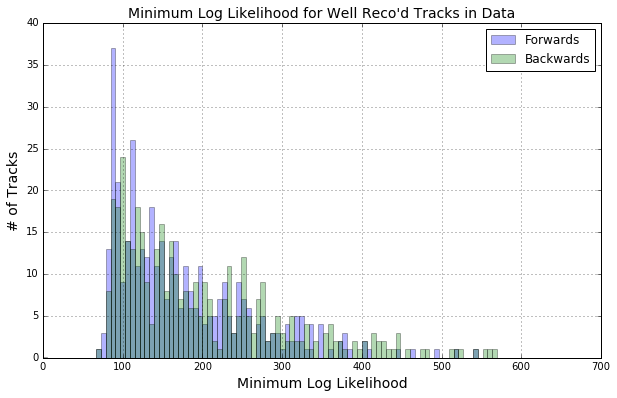

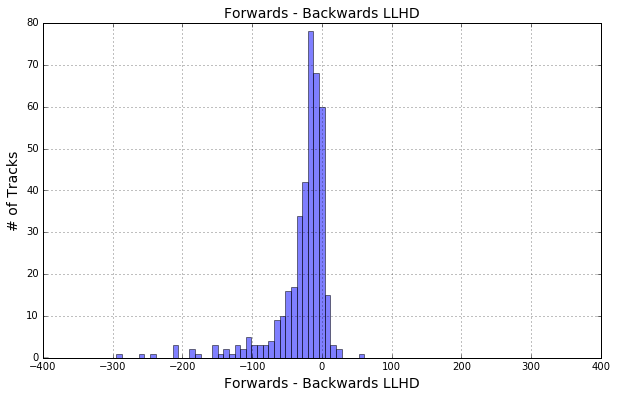

In [16]:
plt.figure(figsize=(10,6))
forwards_llbf = mergesegdf_dict['FORWARDS'].query('not maybe_bad')['llbf'].values
backwards_llbf = mergesegdf_dict['BACKWARDS'].query('not maybe_bad')['llbf'].values
diff_llbf = forwards_llbf-backwards_llbf
thebins = bins=np.linspace(0,600,100)
blah = plt.hist(forwards_llbf,bins=thebins,label='Forwards',alpha=0.3)
blah = plt.hist(backwards_llbf,bins=thebins,label='Backwards',alpha=0.3)
dummy = plt.legend()
dummy = plt.title('Minimum Log Likelihood for Well Reco\'d Tracks in Data',fontsize=14)
dummy = plt.ylabel('# of Tracks',fontsize=14)
dummy = plt.xlabel('Minimum Log Likelihood',fontsize=14)
dummy = plt.grid(True)

plt.figure(figsize=(10,6))
forwards_llbf = mergesegdf_dict['FORWARDS'].query('not maybe_bad')['llbf'].values
backwards_llbf = mergesegdf_dict['BACKWARDS'].query('not maybe_bad')['llbf'].values
diff_llbf = forwards_llbf-backwards_llbf
#mergesegdf_dict['FORWARDS'].hist('llbf')
#mergesegdf_dict['BACKWARDS'].hist('llbf')

blah = plt.hist(diff_llbf,bins=np.linspace(-400,400,100),alpha=0.5)
dummy = plt.title('Forwards - Backwards LLHD',fontsize=14)
dummy = plt.ylabel('# of Tracks',fontsize=14)
dummy = plt.xlabel('Forwards - Backwards LLHD',fontsize=14)
dummy = plt.grid(True)

In [ ]:
mergesegdf_dict['FORWARDS'].columns.values

In [ ]:
mergesegdf_dict['FORWARDS'].tail()